In [209]:
import random
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 10]

In [131]:
file_dlls = []
func_dlls = []
file_funcs = []
files = []
funcs = []
dlls = []
with open('../edge_lists/bin_dll_func.csv') as file:
    for line in file:
        line_split = line.split(",")
        if len(line_split) == 4 and line_split[3] == ' "NAME"\n':
            line_split = [x.strip() for x in line_split]
            line_split = [x.strip('"') for x in line_split]
            file, dll, func = line_split[0:3]
            func = "{}_{}".format(dll, func)
            
            if len(files) < 50:
                file_dlls.append((file, dll))
                func_dlls.append((func, dll))
                file_funcs.append((file, func))
                
                if file not in files:
                    files.append(file)
                    
                if dll not in dlls:
                    dlls.append(dll)
                    
                if func not in funcs:
                    funcs.append(func)

In [132]:
file_dlls = list(set(file_dlls))
func_dlls = list(set(func_dlls))
file_funcs = list(set(file_funcs))

In [133]:
arthrograph = nx.Graph()

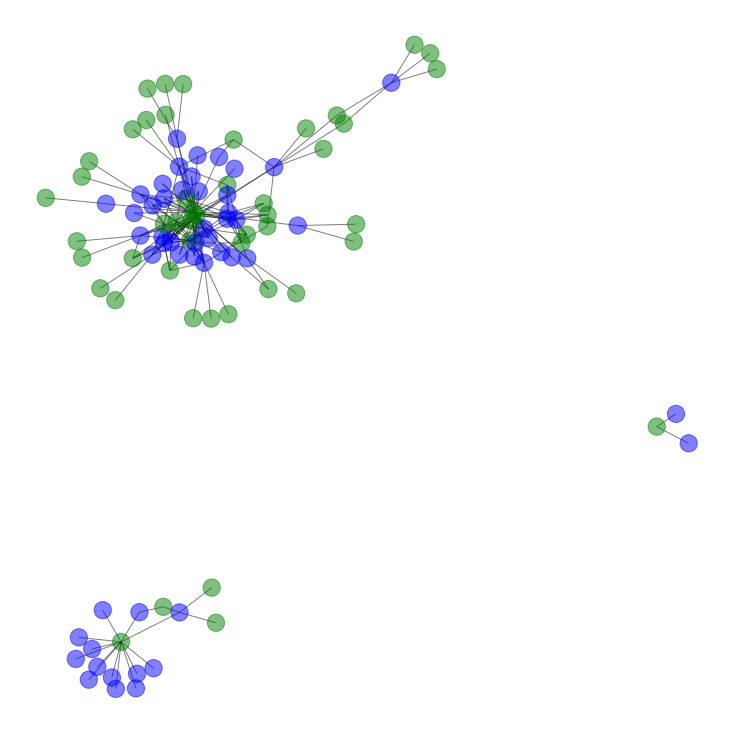

In [134]:
arthrograph.add_edges_from(file_dlls)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(arthrograph, node_color = color_map,with_labels = False, alpha = 0.5)

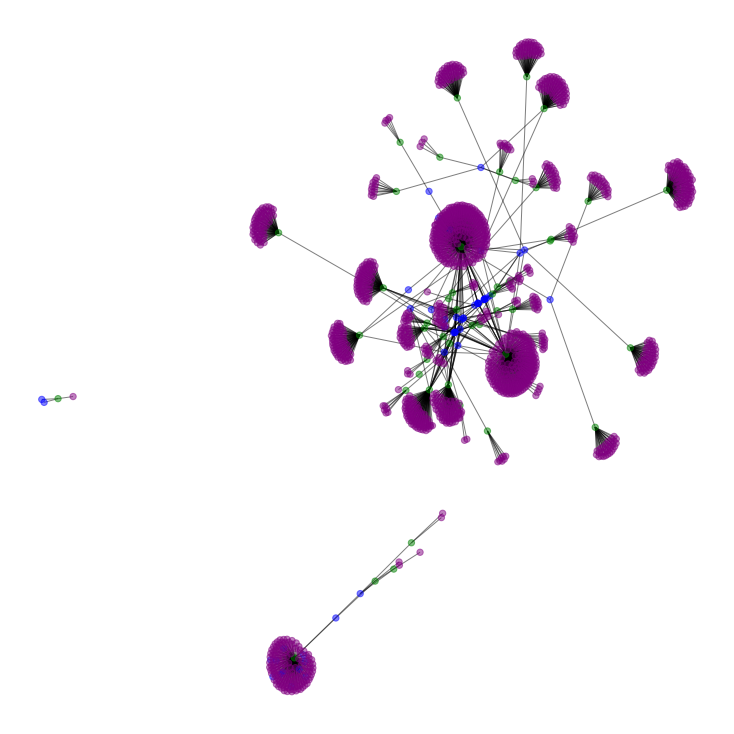

In [135]:
arthrograph.add_edges_from(func_dlls)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    elif node in dlls: 
        color_map.append('green')
    else:
        color_map.append('purple')

nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)

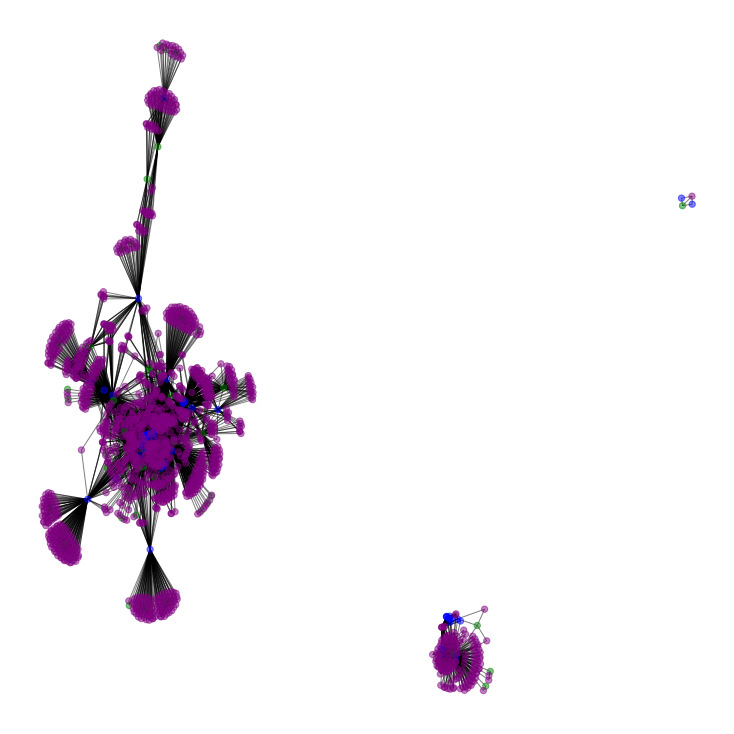

In [136]:
arthrograph.add_edges_from(file_funcs)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    elif node in dlls: 
        color_map.append('green')
    else:
        color_map.append('purple')

nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)

Deepwalk Implementation

In [137]:
walks_per_node = 10
walk_length = 80
walks = []
for node in arthrograph:
    node_walks = 0
    while node_walks < walks_per_node:
        walk = [node]
        cur_node = node
        while len(walk) < walk_length:
            next_node = random.choice(list(arthrograph.neighbors(cur_node)))
            walk.append(next_node)
            cur_node = next_node
        walks.append(walk)
        node_walks += 1
# walks = np.array(walks)
# print(walks.shape)

In [138]:
model = Word2Vec(walks, size=32, window=5, min_count=1, sg=1, hs=0, negative=5, ns_exponent=-0.5)

In [277]:
vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

None
Worm.Win32.WBNA.bul
Trojan-Downloader.Win32.VB.aqqe
Trojan-Downloader.Win32.VB.awih
Trojan.Win32.SuperThreat.m
Trojan-Downloader.Win32.VB.aque
None
Worm.Win32.WBNA.ipa
Worm.Win32.WBNA.bul
Trojan.Win32.VB.azcn
Trojan-Downloader.Win32.VB.avbk
Trojan-Downloader.Win32.VB.avkg
HEUR:Trojan.Win32.Generic
Trojan.Win32.Jorik.Vobfus.fkeu
Trojan-Downloader.Win32.Dapato.frh
Worm.Win32.VBNA.balh


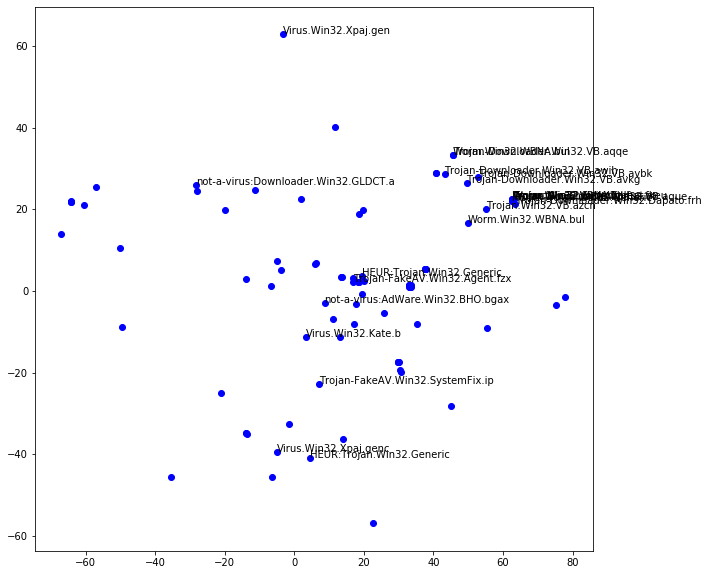

In [289]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for word, pos in df.iterrows():
    if word in files:
        pt_color = 'blue'
        ax.scatter(pos[0], pos[1], color=pt_color)
        response = VT_scans_dict[word]
        scan = None
        if 'scans' in response and 'Kaspersky' in response['scans']:
            scan = response['scans']['Kaspersky']['result']
            ax.annotate(scan, (pos[0], pos[1]))
            if pos[0] > 40:
                print(scan)
    elif word in dlls: 
        pt_color = 'green'
    else:
        pt_color = 'purple'
        
    

GraphSage Implementation

In [140]:
nodes_to_ids = {}
id_map = {}
class_map = {}
ids_to_nodes = {}
node_attr = {}

test_split = 0.1
val_split = 0.1
node_id = 0
for node in files + funcs + dlls:
    if node not in nodes_to_ids:
        nodes_to_ids[node] = node_id
        id_map[str(node_id)] = node_id
        ids_to_nodes[node_id] = node
        rand = random.uniform(0, 1)
        if rand <= test_split:
            node_attr[node_id] = {'test': True, 'val': False}
        elif rand <= test_split + val_split:
            node_attr[node_id] = {'test': False, 'val': True}
        else:
            node_attr[node_id] = {'test': False, 'val': False}

        if node in files:
            class_map[str(node_id)] = [1, 0, 0]
        elif node in funcs:
            class_map[str(node_id)] = [0, 1, 0]
        else:
            class_map[str(node_id)] = [0, 0, 1]
        node_id += 1
file_dlls_ids = [(nodes_to_ids[x[0]], nodes_to_ids[x[1]]) for x in file_dlls]
func_dlls_ids = [(nodes_to_ids[x[0]], nodes_to_ids[x[1]]) for x in func_dlls]
file_funcs_ids = [(nodes_to_ids[x[0]], nodes_to_ids[x[1]]) for x in file_funcs]

In [141]:
edge_attrs = {}
for edge in file_dlls_ids + func_dlls_ids + file_funcs_ids:
    
    if node_attr[edge[0]]['test'] == True or node_attr[edge[1]]['test'] == True:
        edge_attrs[edge] = {'train_removed': True, 'test_removed': False}
        
    elif node_attr[edge[0]]['val'] == True or node_attr[edge[1]]['val'] == True:
        edge_attrs[edge] = {'train_removed': True, 'test_removed': True}
        
    else:
        edge_attrs[edge] = {'train_removed': False, 'test_removed': False}

In [142]:
arthrographsage = nx.Graph()
arthrographsage.add_edges_from(file_dlls_ids)
arthrographsage.add_edges_from(file_funcs_ids)
arthrographsage.add_edges_from(func_dlls_ids)
nx.set_node_attributes(arthrographsage, node_attr)
nx.set_edge_attributes(arthrographsage, edge_attrs)

In [143]:
walks_per_node = 50
walk_length = 5
walks = []
pairs = []
for node in arthrographsage:
    node_walks = 0
    while node_walks < walks_per_node:
        walk = [node]
        cur_node = node
        while len(walk) < walk_length:
            next_node = random.choice(list(arthrographsage.neighbors(cur_node)))
            walk.append(next_node)
            cur_node = next_node
            if cur_node != node:
                pairs.append((node, cur_node))
        walks.append(walk)
        node_walks += 1

In [144]:
with open('../arthropod-G.json', 'w') as fp:
    json.dump(nx.node_link_data(arthrographsage), fp)

    
with open('../arthropod-id_map.json', 'w') as fp:
    json.dump(id_map, fp)

with open('../arthropod-class_map.json', 'w') as fp:
    json.dump(id_map, fp)

with open('../arthropod-walks.txt', "w") as fp:
    fp.write("\n".join([str(p[0]) + "\t" + str(p[1]) for p in pairs]))

In [210]:
graphsage_emb = np.load('../graphsage_embeddings/val.npy')

ids_to_rows = []
with open('../graphsage_embeddings/val.txt', "r") as fp:
    for line in fp.readlines():
        ids_to_rows.append(int(line.strip('\n')))

In [246]:
VT_scans = json.load(open('../VT_Scans.json'))
VT_scans_dict = {}
for scan in VT_scans:
    VT_scans_dict[scan['resource']] = scan

In [297]:
vocab = ids_to_rows
X = graphsage_emb
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

HEUR:Trojan.Win32.Generic
Trojan-Downloader.Win32.VB.avbk
Trojan.Win32.Jorik.Vobfus.fkeu
Worm.Win32.VBNA.balh
None
Trojan-Downloader.Win32.VB.aqqe


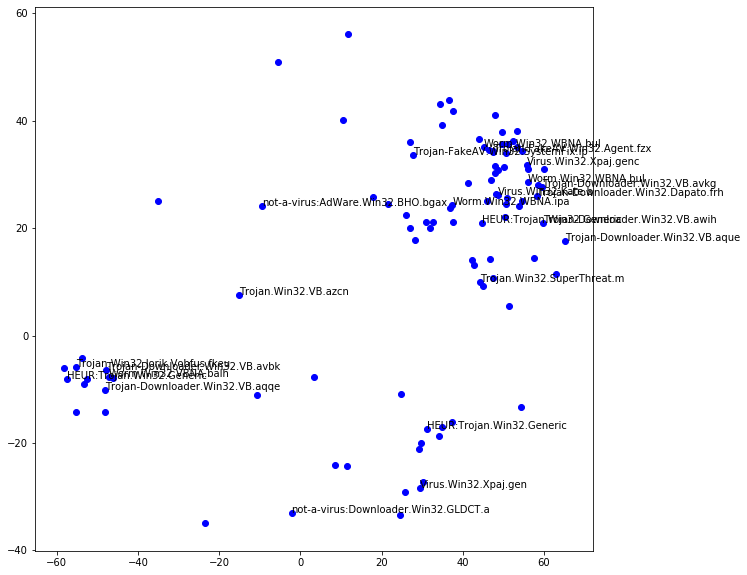

In [299]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for word, pos in df.iterrows():
    if ids_to_nodes[word] in files:
        pt_color = 'blue'
        ax.scatter(pos[0], pos[1], color=pt_color)
        response = VT_scans_dict[ids_to_nodes[word]]
        
        if 'scans' in response and 'Kaspersky' in response['scans']:
            scan = response['scans']['Kaspersky']['result']
            if pos[0] < -40:
                print(scan)
            ax.annotate(scan, (pos[0], pos[1]))
    elif ids_to_nodes[word] in dlls: 
        pt_color = 'green'
    else:
        pt_color = 'purple'
        
    

In [225]:
import requests
import time
import json

scanned_nodes = []
responses = []

url = 'https://www.virustotal.com/vtapi/v2/file/report'
api_key = '<API_Key>'

In [ ]:
for node in files:
    if node not in scanned_nodes:
        params = {'apikey': api_key, 'resource': node}
        response = requests.get(url, params=params)
        
        if response.status_code == 204:
            time.sleep(60)
            response = requests.get(url, params=params)
        scanned_nodes.append(node)
        responses.append(response.json())

In [240]:
with open('../VT_Scans.json', 'w', encoding='utf-8') as f:
    json.dump(responses, f, ensure_ascii=False, indent=4)